# Task 3
Train a convolutional neural network on the following dataset:
https://www.kaggle.com/paultimothymooney/breast-histopathology-images


In [0]:
#!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zhangtanliu0720","key":"92e0c4f189ef1148b56abe40f9bc3829"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 1.48G/1.49G [00:15<00:00, 135MB/s]
100% 1.49G/1.49G [00:15<00:00, 104MB/s]


In [5]:
!unzip breast-histopathology-images.zip

Archive:  breast-histopathology-images.zip
  inflating: IDC_regular_ps50_idx5.zip  


In [0]:
# !mkdir ~/.kaggle/IDC_regular_ps50_idx5

In [0]:
!unzip IDC_regular_ps50_idx5.zip > ~/.kaggle/IDC_regular_ps50_idx5

In [0]:
#%cd ~/.kaggle/IDC_regular_ps50_idx5

/root/.kaggle/IDC_regular_ps50_idx5


In [0]:
!ls 

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

## 3.1 Start with a model without residual connections (using batch normalization is likely to be helpful and you should try it, whether you use dropout is your choice).

In [8]:
from glob import glob

images = glob('**/**/*.png', recursive=True)
print("total images ", len(images))

total images  832572


There are total **832572** images in the given dataset. 

In [0]:
import random
from random import sample 
random.seed(0)

images_sample = sample(images, 40000)

In [0]:
import fnmatch

class0 = '*class0.png'
class1 = '*class1.png'

In [0]:
import cv2
import numpy as np

X = []
y = []
for i in range(len(images_sample)):
    img = cv2.resize(cv2.imread(images_sample[i]), (50,50), interpolation=cv2.INTER_CUBIC)
    X.append(img)
    if fnmatch.fnmatch(images_sample[i],class0):
        y.append(0)
    elif fnmatch.fnmatch(images_sample[i],class1):
        y.append(1)
    #print(i)


The sampled dataset is imbalanced, as the size of class 0 is nearly 3 times of class 1. With imbalanced dataset, standard performance measures may not be as effective and would need modification. Thus, we use the under sampling method to get the balanced dataset:

In [12]:
print("class balance: ", np.bincount(y))

class balance:  [28785 11215]


In [0]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(np.array(X).reshape(40000,-1), y)

In [14]:
print("class balance: ", np.bincount(y_resampled))

class balance:  [11215 11215]


After resampling the dataset, the target class is balanced now, with half from class 0, the other half from class 1.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, 
                                                    stratify=y_resampled, 
                                                    random_state=0)

In [0]:
X_train = X_train.reshape(-1,50,50,3)/255.0
X_test = X_test.reshape(-1,50,50,3)/255.0

In [0]:
import matplotlib.pylab as plt
#plt.imshow(X_train[48])
#_ = plt.title("sample image")

Before build the model, let's have a look at some sample images:

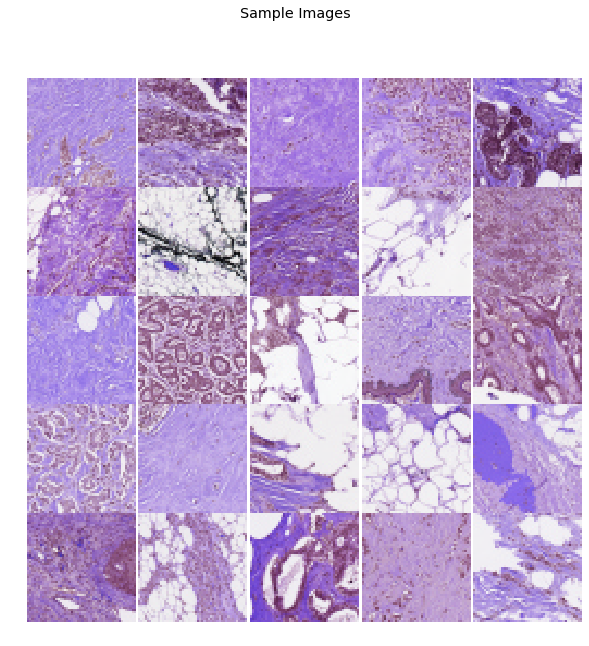

In [0]:
# Plot Multiple sample Images

i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)

plt.suptitle("Sample Images", fontsize="x-large")
for l in X_train[:25]:
    #im = cv2.imread(l)
    #im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(l) 
    plt.axis('off')
    i += 1


One-hot encoded the target:

In [18]:
import keras
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, add, Activation
from keras.layers import Dropout
from keras.layers import BatchNormalization

Build a CNN model without residual connections, but using batch normalization and drop out:

In [0]:
simple_model = Sequential()
simple_model.add(Conv2D(8, kernel_size=(2, 2),
                     input_shape=(50,50,3)))

#simple_model.add(Activation('relu'))
#simple_model.add(Conv2D(8, (3, 3), activation='relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))
#simple_model.add(BatchNormalization(momentum=0.5))
simple_model.add(Dropout(0.75))
simple_model.add(Flatten())
simple_model.add(Dense(16, activation='relu'))
simple_model.add(BatchNormalization(momentum=0.5))
#simple_model.add(Dropout(0.5))
simple_model.add(Dense(2, activation='softmax'))

simple_model.compile(optimizer="adam",loss="categorical_crossentropy", 
                  metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
history_simple = simple_model.fit(X_train, y_train, batch_size=128,
                            epochs=10, verbose=1, validation_split=.1)

Instructions for updating:
Use tf.cast instead.
Train on 15319 samples, validate on 1703 samples
Epoch 1/10
15319/15319 [==============================] - 4s 285us/step - loss: 0.5639 - acc: 0.7269 - val_loss: 0.4877 - val_acc: 0.7769
Epoch 2/10
15319/15319 [==============================] - 1s 92us/step - loss: 0.4768 - acc: 0.7881 - val_loss: 0.5171 - val_acc: 0.7663
Epoch 3/10
15319/15319 [==============================] - 1s 92us/step - loss: 0.4602 - acc: 0.7938 - val_loss: 0.4801 - val_acc: 0.7804
Epoch 4/10
15319/15319 [==============================] - 1s 92us/step - loss: 0.4556 - acc: 0.7937 - val_loss: 0.4676 - val_acc: 0.7833
Epoch 5/10
15319/15319 [==============================] - 1s 92us/step - loss: 0.4457 - acc: 0.8015 - val_loss: 0.4828 - val_acc: 0.7839
Epoch 6/10
15319/15319 [==============================] - 1s 91us/step - loss: 0.4435 - acc: 0.8045 - val_loss: 0.4647 - val_acc: 0.7857
Epoch 7/10
15319/15319 [==============================] - 1s 92us/step - loss: 0

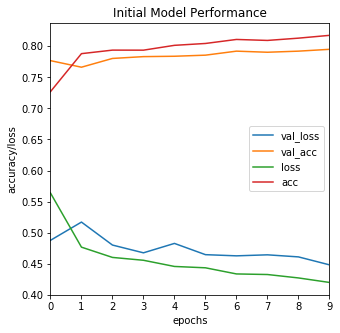

In [0]:
import pandas as pd

plt.rcParams['figure.figsize'] = (5.0, 5.0)
pd.DataFrame(history_simple.history).plot()
plt.ylabel("accuracy/loss")
plt.xlabel("epochs")
_ = plt.title("Initial Model Performance")

In [0]:
score = simple_model.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.454
Test Accuracy: 0.793


## 3.2 Augment the data using rotations, mirroring and possibly other transformations. How much can you improve your original model by data augmentation?

Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

Augment the image data by setting:  
1. **rotation_range=40**  - randomly rotate images in the range [0, 20] degree;  
2. **width_shift_range=0.2** - randomly shift images horizontally with 20% of total width;  
3. **height_shift_range=0.2** - randomly shift images vertically with 20% of total height;  
4. **shear_range=0.2** - shear Intensity as 0.2 (Shear angle in counter-clockwise direction in degrees);
5. **zoom_range=0.2** - zoom range [0.8,1.2] for random zoom;
6. **horizontal_flip=True** - randomly flip inputs horizontally;
7. **vertical_flip=True** - Randomly flip inputs vertically;
8. **fill_mode='nearest'** - points outside the boundaries of the input are filled according to the nearest one.
   

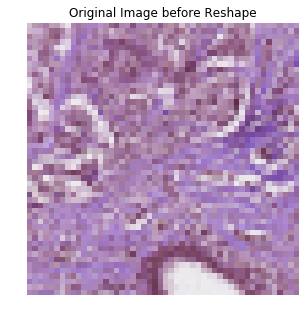

In [0]:
plt.imshow(X[12])
_ = plt.title("Original Image before Reshape")
_ = plt.axis("off")

To have a better undersatnding of the reshaping process, a original image before reshaping and its sample images after reshaping are dispalyed. 

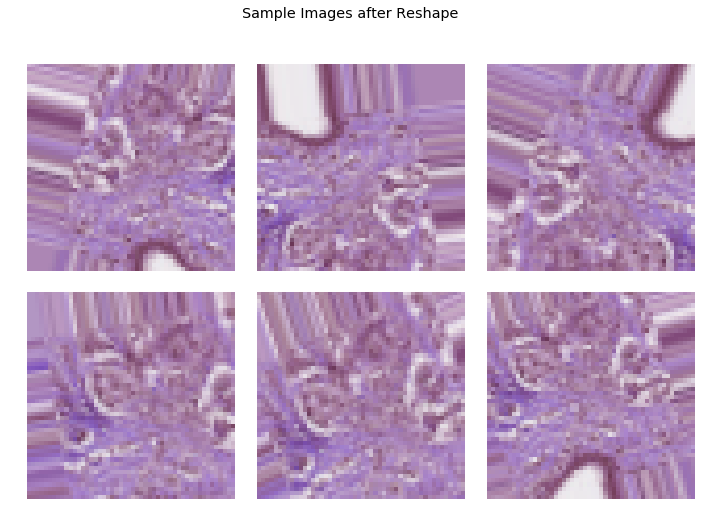

In [0]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.suptitle("Sample Images after Reshape", fontsize='x-large')
i = 0
for batch in datagen.flow(X[12].reshape(1,50,50,3), batch_size=128):
    if i > 5:
        break
    plt.subplot(2,3,i+1)
    plt.imshow(batch.reshape(50,50,3)/255.0)
    plt.axis('off')
    #print(batch.reshape(50,50,3)/300.0)
    i += 1
    

Compared the sample reshaped images with the original image, it can be observed that these images are been rotate, zoomed, or hlipped, etc.

In [0]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.1,
                                                    stratify=y_train, 
                                                    random_state=0)
aug_history = simple_model.fit_generator(datagen.flow(X_train_,y_train_, batch_size=128),
                        steps_per_epoch=len(X_train_) / 128, epochs=10,class_weight=[1, 1], validation_data = [X_val, y_val])

Epoch 1/10
120/119 [==============================] - 11s 90ms/step - loss: 0.4569 - acc: 0.7990 - val_loss: 0.4361 - val_acc: 0.8074
Epoch 2/10
120/119 [==============================] - 12s 99ms/step - loss: 0.4475 - acc: 0.8039 - val_loss: 0.4228 - val_acc: 0.8168
Epoch 3/10
120/119 [==============================] - 10s 86ms/step - loss: 0.4450 - acc: 0.8042 - val_loss: 0.4409 - val_acc: 0.7927
Epoch 4/10
120/119 [==============================] - 11s 91ms/step - loss: 0.4443 - acc: 0.8052 - val_loss: 0.4222 - val_acc: 0.8115
Epoch 5/10
120/119 [==============================] - 11s 94ms/step - loss: 0.4384 - acc: 0.8076 - val_loss: 0.4191 - val_acc: 0.8168
Epoch 6/10
120/119 [==============================] - 11s 89ms/step - loss: 0.4394 - acc: 0.8082 - val_loss: 0.4274 - val_acc: 0.8127
Epoch 7/10
120/119 [==============================] - 11s 88ms/step - loss: 0.4343 - acc: 0.8087 - val_loss: 0.4602 - val_acc: 0.7868
Epoch 8/10
120/119 [==============================] - 11s 88ms

In [0]:
score = simple_model.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.441
Test Accuracy: 0.808


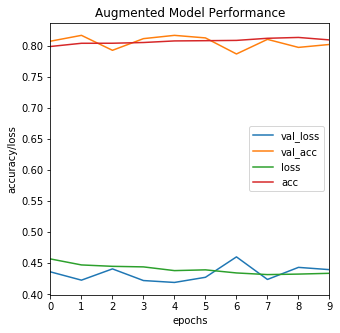

In [0]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
pd.DataFrame(aug_history.history).plot()
plt.ylabel("accuracy/loss")
plt.xlabel("epochs")
_ = plt.title("Augmented Model Performance")

By applying the data augmentation techniques, some minor changes such as flips or translations or rotations, generating more data for the nural network model. The CNN (convolutional neural network) can robustly classify objects even if its placed in different orientations. 

Compared with the original CNN model in ***question 3.1***, the model trained with augmentation datasets has a better performance with accuacry been improved to 80% level. By performing augmentation, it prevents the CNN model from learning irrelevant patterns, essentially boosting overall performance.

## 3.3 Build a deeper model using residual connections. Show that you can build a deep model that would not be able to learn if you remove the residual connections (i.e. compare a deep model with and without residual connections while the rest of the architecture is constant).

n this section, two CNN models are bulit: one using the residual connections, the other not. Expect using the redidual connections or not, the rest of the architecture of two CNN models are all the same. The performance of two models will be compared to check out the significance of adding residual connections.

### 3.3.1 CNN model without residual connections

In [0]:
from keras.models import Model

model = Sequential()
# 1
model.add(Conv2D(128, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(50,50,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 2
model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
# 3
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# 4
model.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# # 5
#model.add(Conv2D(256, kernel_size=(3, 3),
#                      activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer="adam",loss="categorical_crossentropy", 
                  metrics=['accuracy'])


In [21]:
history_nores = model.fit(X_train, y_train, batch_size=128,
                            epochs=10, verbose=1, validation_split=.1)

Instructions for updating:
Use tf.cast instead.
Train on 15139 samples, validate on 1683 samples
Epoch 1/10
15139/15139 [==============================] - 13s 864us/step - loss: 0.6687 - acc: 0.5811 - val_loss: 0.5703 - val_acc: 0.7605
Epoch 2/10
15139/15139 [==============================] - 6s 423us/step - loss: 0.5424 - acc: 0.7540 - val_loss: 0.5045 - val_acc: 0.7600
Epoch 3/10
15139/15139 [==============================] - 6s 426us/step - loss: 0.5088 - acc: 0.7716 - val_loss: 0.5078 - val_acc: 0.7582
Epoch 4/10
15139/15139 [==============================] - 6s 428us/step - loss: 0.5129 - acc: 0.7716 - val_loss: 0.4943 - val_acc: 0.7689
Epoch 5/10
15139/15139 [==============================] - 6s 425us/step - loss: 0.4939 - acc: 0.7830 - val_loss: 0.4790 - val_acc: 0.7950
Epoch 6/10
15139/15139 [==============================] - 6s 428us/step - loss: 0.4834 - acc: 0.7880 - val_loss: 0.4617 - val_acc: 0.7926
Epoch 7/10
15139/15139 [==============================] - 6s 425us/step - 

In [22]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.440
Test Accuracy: 0.804


Building a CNN model without using residual connections, the test loss is 0.425, and test accuracy is 0.809.

### 3.3.2 CNN model with residual connections

In [0]:
inputs = Input(shape=(50, 50, 3))
# 1
conv1_1 = Conv2D(128, (3, 3), activation='relu',
                 padding='same')(inputs)
conv1_2 = Conv2D(64, (3, 3), activation='relu',
                 padding='same')(conv1_1)

maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
# 2
conv2_1 = Conv2D(64, (3, 3), activation='relu',
                 padding='same')(maxpool1)
conv2_2 = Conv2D(64, (3, 3), activation='relu',
                 padding='same')(conv2_1)
# 1-2
skip12 = add([maxpool1, conv2_2])
# maxpool2 = MaxPooling2D(pool_size=(2, 2))(skip2)
# 3
conv3_1 = Conv2D(32, (3, 3), activation='relu',
                 padding='same')(skip12)
conv3_2 = Conv2D(64, (3, 3), activation='relu',
                 padding='same')(conv3_1)
# 2-3
skip23 = add([skip12, conv3_2])
# 4
conv4_1 = Conv2D(16, (3, 3), activation='relu',
                 padding='same')(skip23)
conv4_2 = Conv2D(64, (3, 3), activation='relu',
                 padding='same')(conv4_1)
# 3-4
skip34 = add([skip23, conv4_2])
maxpool2 = MaxPooling2D(pool_size=(2, 2))(skip34)

flat = Flatten()(maxpool2)
dense = Dense(64, activation='relu')(flat)
dropout = Dropout(0.5)(dense)
predictions = Dense(2, activation='softmax')(dropout)
res_model = Model(inputs=inputs, outputs=predictions)

In [25]:
res_model.compile(optimizer="adam",loss="categorical_crossentropy", 
                  metrics=['accuracy'])

history_res = res_model.fit(X_train, y_train, batch_size=128,
                            epochs=10, verbose=1, validation_split=.1)

Train on 15139 samples, validate on 1683 samples
Epoch 1/10
15139/15139 [==============================] - 10s 650us/step - loss: 0.4172 - acc: 0.8232 - val_loss: 0.4002 - val_acc: 0.8223
Epoch 2/10
15139/15139 [==============================] - 9s 603us/step - loss: 0.3996 - acc: 0.8289 - val_loss: 0.4087 - val_acc: 0.8111
Epoch 3/10
15139/15139 [==============================] - 9s 605us/step - loss: 0.3919 - acc: 0.8331 - val_loss: 0.3781 - val_acc: 0.8330
Epoch 4/10
15139/15139 [==============================] - 9s 605us/step - loss: 0.3858 - acc: 0.8349 - val_loss: 0.4000 - val_acc: 0.8277
Epoch 5/10
15139/15139 [==============================] - 9s 605us/step - loss: 0.3732 - acc: 0.8449 - val_loss: 0.3732 - val_acc: 0.8378
Epoch 6/10
15139/15139 [==============================] - 9s 608us/step - loss: 0.3721 - acc: 0.8462 - val_loss: 0.3787 - val_acc: 0.8372
Epoch 7/10
15139/15139 [==============================] - 9s 614us/step - loss: 0.3539 - acc: 0.8511 - val_loss: 0.4473 - 

In [26]:
score = res_model.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.401
Test Accuracy: 0.838


Building another CNN model using residual connections, the test loss is 0.417, the test accuracy is 0.814.

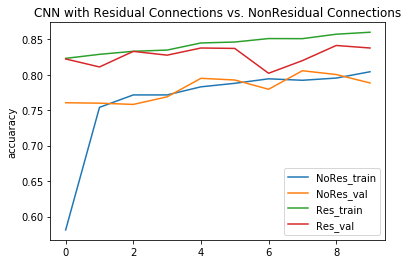

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(pd.DataFrame(history_nores.history)[['acc']], label='NoRes_train')
plt.plot(pd.DataFrame(history_nores.history)[['val_acc']], label='NoRes_val')
plt.plot(pd.DataFrame(history_res.history)[['acc']], label='Res_train')
plt.plot(pd.DataFrame(history_res.history)[['val_acc']], label='Res_val')
plt.legend(loc='best')
plt.ylabel("accuaracy")
plt.xticks(np.arange(0, 10, step=2))
_ = plt.title("CNN with Residual Connections vs. NonResidual Connections")
plt.show()
plt.show()

The plot above demonstrates the accuarcy of CNN models with or without Residual Connections. Overall, the performance of CNN model using residual connecstions is better than the performance of model without, as a result of preventing vanishing gradients problems in deep neural networks. The skipping step effectively simplifies the network, using fewer layers in the initial training stages. 

The CNN with residual connections learns faster. However, it is observed that the influence of adding Residual Connecstions is not significant enough. This possibly because the CNN used here is not deep enough to have a serious vanishing gradient problem.